# Inversions with okapy and SciPy

A simple inversion making use of the Powell algorithm built into the scipy.optimize.minimize function, the Okada model in okapy and our downsampled data in 'okinv' format to try to obtain a best-fitting model of an dike.

## Set it up! 

Let's start with some dependencies:

In [12]:
from okapy import rect_tensile_fault, los_penalty_tensile
from math import sin, cos, tan, radians, floor
from matplotlib import cm, colors
from scipy.optimize import minimize, Bounds
import numpy as np
import matplotlib.pyplot as plt

## Defining the data, model parameters and elastic constants

Load in the downsampled interfrogram data:

In [13]:
data = np.loadtxt('../../elazig_asc.okinv', delimiter=' ') # or wherever the file is on your system!
data[:,0]*=1000  # convert x coord from km to m
data[:,1]*=1000  # convert y coord from km to m

Let's specify some parameters for our models: starting guesses and uncertainties

In [14]:
# for each quantity, starting guess is the first value, sigma the second
strike = [60, 10]        # in degrees
dip = [85, 10]           # in degrees
opening = [2, 0.5]          # in m
xc = [500000, 5000]        # x coord of dislocation centroid, in m 
yc = [4240000, 5000]       # y coord of dislocation centroid, in m
zc = [2000 200]            # z coord of dislocation centroid, in n
as_length = [25000, 2000]     # along-strike dislocation length, in m
dd_width = [4000, 2000]      # down-dip dislocation width, in m

fpstart = np.array([strike[0], dip[0], opening[0], xc[0], yc[0], zc[0], as_length[0], dd_width[0]])
fpsigma = np.array([strike[1], dip[1], opening[1], xc[1], yc[1], zc[1], as_length[1], dd_width[1]])

# let's calculate some 2-sigma bounds on these starting values:
fplowb = fpstart-2*fsigma
fphighb = fpstart+2*fsigma

# find a random starting model (assume flat pdf between lower and upper bounds)
fparams_restart = fpstart + np.multiply(((np.random.random_sample(9)*4)-2),fpsigma)
    
# and output the starting model    
print("example starting fault parameters:")
print('  strike:',fparams_restart[0],'dip:',fparams_restart[1],'opening:',fparams_restart[2])
print('  xc:',fparams_restart[3],'yc:',fparams_restart[4],'zc:',fparams_restart[5])
print('  length:',fparams_restart[6],'width:',fparams_restart[7])

example starting fault parameters:
  strike: 78.13464670534881 dip: 68.39736501405272 rake: -36.98197463010379 slip: 2.546256003003453
  xs: 500635.9960664817 ys: 4236822.5496240435
  length: 25433.230856498274 top: 814.3464800774218 bottom: 13136.030687169972


Finally, let's define some elastic parameters, using some standard values:

In [15]:
eparams = np.array([30e9, 30e9])  # 1st and 2nd Lame elastic parameters; try 30 GPa for both

## Evaluating the penalty function for a random starting model

We now have all the elements we need to calculate an initial penalty value, using the los_penalty_fault function in okapy. This function has the following syntax: 

<center>penalty=los_penalty_fault(fparams, eparams, data)</center>

The output argument, 'penalty' is the total squared misfit of the model to the data, accounting for a zero-level shift.

There are three input arguments, for which we have already seen examples. 'fparams' is a vector of fault parameters, of the type we have already seen (e.g. fstart, fparams_restart), 'eparams' contains elastic constants, and 'data' is a matrix of data point locations, values and line-of-sight parameters. (You may recognize that these are the same inputs that we used to compute our forward model displacements in the forward modeling notebook...)

For example, we can evaluate the penalty function for our starting model:

In [16]:
init_penalty = los_penalty_tensile(fparams_restart, eparams, data)

print('initial penalty:',init_penalty, 'm^2')

initial penalty: 17.97845277912776 m^2


## Optimizing fault parameters using the Powell algorithm in SciPy

The <a href="https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html#constrained-minimization-of-multivariate-scalar-functions-minimize">'optimize.minimize'</a> function in SciPy is a very flexible optimization package that can apply several different optimization algorithms to the problem of minimizing a specified nonlinear function. Here we want to find the parameter values that minimize our penalty function, 'los_penalty_fault'.

We will make use of the <a href="https://en.wikipedia.org/wiki/Powell%27s_method">Powell algorithm</a>, which is a 'direction set' minimization algorithm that, in our experience, works well for these sorts of problems. It allows us to specify bounds on the inversion parameters, which is particularly useful for limiting the range of models it will test. The Powell algorithm also requires a starting guess, for which we will use our random starting model ('fparams_restart'). 

Note that our 'los_penalty_fault' function has three input arguments &ndash; the fault parameters, the elastic parameters and the data. We only want the Powell algorithm to vary the first of these (which it does by default), but we need to pass all three to properly evaluate the penalty. scipy.optimize allows us to pass the additional arguments to the penalty function using the 'args' option.

In [17]:
# the scipy.optimize way of setting bounds:
fpbounds = Bounds(fplowb,fphighb)

# and run the Powell algorithm minimizer! 
results = minimize(los_penalty_tensile, fparams_restart, args=(eparams, data),  method='Powell', 
                   bounds=fpbounds)

We can look at the results of this optimization run, by printing the contents of 'results':

In [18]:
results

   direc: array([[-5.51591165e-01, -3.06165224e-05, -8.13243888e-02,
         1.21699266e-05,  5.64466105e+02,  2.86693489e+02,
        -2.55979287e-02,  3.26438835e+01,  7.82830673e+02],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.58743341e+00,  5.42814879e-01, -9.46880903e+00,
         2.47049822e-01,  1.20424754e+03, -1.14701510e+02,
        -5.69888966e+02, -1.70310308e+01,  9.92750925e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.10252960e-01,  1.60053650e-06, -1.01687801e-03,
         1.05613553e-07,  3.65325285e+00,  7.57647281e+00,
         7.05344750e-03,  6.96278402e-01,  6.98921360e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,

Of these, 'direc' shows directions in parameter space that the algorithm took; 'fun' is the final, minimum value of the penalty function; 'nfev' is the number of penalty function evaluations (which might explain the delay in getting a result); 'nit' is the number of iterations (direction changes), and 'x' is the final set of fault parameters (that correspond to the minimum penalty, 'fun'). 

We can extract the values of interest here, and hopefully verify that the final penalty is smaller than the one we started with:  

In [19]:
fparams_out = results.x
output_penalty = results.fun

print("final fault parameters:")
print('  strike:',fparams_out[0],' dip:',fparams_out[1],' opening:',fparams_out[2])
print('  xc:',fparams_out[3],' yc:',fparams_out[4],' zc:',fparams_out[5])
print('  length:',fparams_out[6],' width:',fparams_out[7])
print('initial penalty:',init_penalty,'m^2  final penalty:',output_penalty,'m^2')

final fault parameters:
  strike: 61.75665053078538  dip: 104.9999650050302  rake: 10.340869469829356  slip: 1.0000482298967865
  xs: 499429.2572369563  ys: 4240057.636516777
  length: 28999.997785783497  top: 1433.0045366703112  bottom: 12487.083203284299
initial penalty: 17.97845277912776 m^2  final penalty: 0.1301886620052135 m^2


## Local vs global minima

Technically, what our single run of the Powell algorithm has found is a 'local minimum' of the penalty function. For complicated functions, such as the penalty function of an Okada model fitted to InSAR data that contain noise (our situation!) it is usually the case that there are several, or perhaps many such minima. It's analous to finding the deepest point on the surface of the Moon, by always taking the steepest path downhill. Eventually, you will walk into a crater, and find your way to the bottom of it. But what if two craters over, there is a deeper one?

The problem of finding a 'global minimum' of the penalty function, corresponding to the best-fitting of all possible models, is not straightforward or exact. Following the crater analogy, it can be very dependent on your starting location &ndash; sometimes you need to start away from smaller holes in order to walk into bigger ones! Which is why, when we set up this optimization problem, we randomized our starting guess of the answer. You also have to be careful to specify solution bounds large enough that the neighborhood of the best answer is covered. 

By comparing your answer with your classmates' answers, which originated from different random starting guesses, within a fairly conservative set of bounds,  you should be able to see if there are smaller misfits out there. Or alternatively, if you don't want to crowdsource the problem, you could loop through a large number (say 100) of optimization runs with randomised starting guesses (you will often see these described as 'Monte Carlo restarts'), and retain the best models and penalties from each, in order to find a global minimum solution. 

Paste the best answer you can find here:

In [20]:
best_fparams=[6.06231351e+01, 1.04999984e+02, 2.59162348e+00, 1.00018395e+00,
       4.99746476e+05, 4.24024712e+06, 2.89999974e+04, 2.11015719e+03]
best_penalty=0.11499180622286244

## It is good practice to plot your results and residuals

We can use the routines we developed in earlier notebooks to do this!

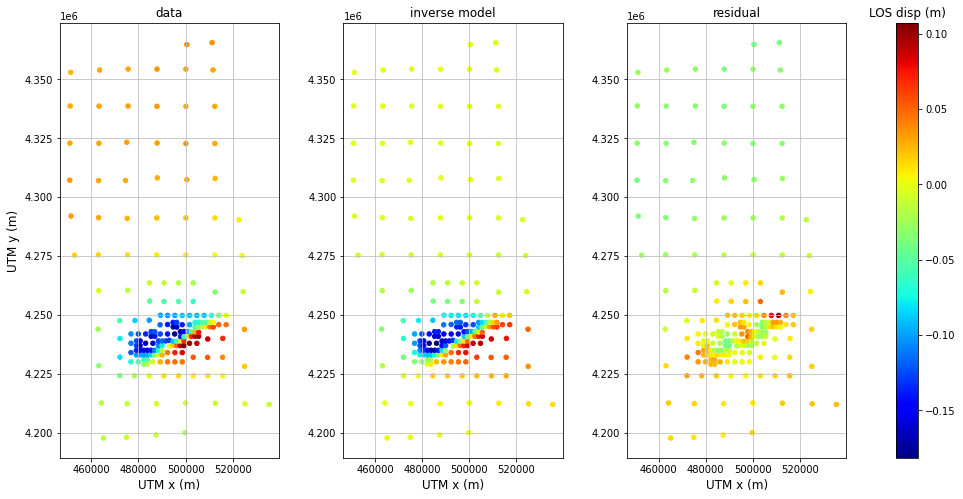

In [21]:
# calculate the displacements
model_los_disps = rect_tensile_fault(best_fparams, eparams, data)

# calculate the mean residual
zero_shift = np.mean(data[:,2]-model_los_disps)

# calculate the residual without nuisances...
shifted_data = data[:,2]-zero_shift
residual_los_disps = model_los_disps-shifted_data

# color limits based on the shifted data
cmin, cmax = shifted_data.min(), shifted_data.max()

fig, (ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(18,8))
axlist = [ax1,ax2,ax3]   # handles for your subplots

# scatter with colormap mapping to z value
scat=ax1.scatter(data[:,0],data[:,1],s=20,c=shifted_data, marker = 'o', cmap = cm.jet, vmin = cmin, vmax = cmax);
ax1.set_xlabel("UTM x (m)",fontsize=12)
ax1.set_ylabel("UTM y (m)",fontsize=12)
ax1.title.set_text('data')
ax1.grid(True,linestyle='-',color='0.75')
ax1.set_aspect('equal')

# scatter with colormap mapping to z value
scat=ax2.scatter(data[:,0],data[:,1],s=20,c=model_los_disps, marker = 'o', cmap = cm.jet, vmin = cmin, vmax = cmax);
ax2.set_xlabel("UTM x (m)",fontsize=12)
ax2.title.set_text('inverse model')
ax2.grid(True,linestyle='-',color='0.75')
ax2.set_aspect('equal')

# scatter with colormap mapping to z value
scat=ax3.scatter(data[:,0],data[:,1],s=20,c=residual_los_disps, marker = 'o', cmap = cm.jet, vmin = cmin, vmax = cmax);
ax3.set_xlabel("UTM x (m)",fontsize=12)
ax3.title.set_text('residual')
ax3.grid(True,linestyle='-',color='0.75')
ax3.set_aspect('equal')

clb=fig.colorbar(scat,ax=axlist)
clb.ax.set_title('LOS disp (m)')

plt.show();